## **Dataset**

In [1]:
!pip install -q datasets torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not c

In [2]:
from datasets import load_dataset

ds = load_dataset("bahjat-kawar/tedbench", split="val")

README.md:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/133M [00:00<?, ?B/s]

Generating val split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [3]:
import torch
from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_encoder = SentenceTransformer("all-mpnet-base-v2").to(device)

2025-04-12 03:48:46.507710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744429726.765260      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744429726.838939      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor()
])

In [5]:
from torch.utils.data import Dataset, DataLoader

class TextGuidedImageGenerationDataset(Dataset):
    def __init__(self, dataset, transform, text_encoder, device):
        self.dataset = dataset
        self.transform = transform
        self.text_encoder = text_encoder
        self.device = device
        self.original_images = dataset["original_image"]
        self.captions = dataset["caption"]
        self.edited_images = dataset["edited_image"]
        self.embed_captions = text_encoder.encode(
            self.captions, convert_to_tensor=True, device=self.device
        )

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        # get an original image
        original_image = self.original_images[idx]
        original_image = self.transform(original_image)

        # get a output image
        edited_image = self.edited_images[idx]
        edited_image = self.transform(edited_image)

        # get a text
        caption = self.captions[idx]
        caption_embedding = self.embed_captions[idx]
        return {
            "original_image": original_image,
            "edited_image": edited_image,
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

train_ds = TextGuidedImageGenerationDataset(
    ds, transform, text_encoder, device
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
sample = next(iter(train_ds))

## **Model**

In [7]:
import math
import torch.nn as nn
from torchcfm.models.unet import UNetModel

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class UNetModelWithTextEmbedding(UNetModel):
    def __init__(self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_channels, num_channels*2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_channels*2, num_channels*4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.embedding_layer = nn.Linear(embedding_dim, num_channels*4)
        self.fc = nn.Linear(num_channels*12, num_channels*4)

    def forward(self, t, x, text_embeddings=None, original_image=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if (text_embeddings is not None) and (original_image is not None):
            text_embedded = self.embedding_layer(text_embeddings) #Bx128
            image_embedded = self.image_encoder(original_image).squeeze(2, 3) #Bx128
            emb = torch.cat([emb, text_embedded, image_embedded], dim=1)
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

## **Training**

In [8]:
model = UNetModelWithTextEmbedding(
    dim=(3, 64, 64), num_channels=32, num_res_blocks=1, embedding_dim=768
).to(device)


if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

Using 2 GPUs


In [9]:

from tqdm import tqdm

n_epochs = 5000
for epoch in tqdm(range(n_epochs)):
    losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        original_image = batch["original_image"].to(device)
        edited_image = batch["edited_image"].to(device)
        caption_embedding = batch["caption_embedding"].to(device)

        x1 = edited_image
        x0 = torch.randn_like(x1).to(device)
        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x0
        ut = x1 - x0

        t = t.squeeze()

        vt = model(t, xt, text_embeddings=caption_embedding, original_image=original_image)
        loss = torch.mean(((vt - ut) ** 2))

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1} /{n_epochs}], Loss: {avg_loss:.4f}")


 10%|█         | 500/5000 [46:40<6:58:14,  5.58s/it]

Epoch [500 /5000], Loss: 0.0553


 20%|██        | 1000/5000 [1:33:15<6:09:37,  5.54s/it]

Epoch [1000 /5000], Loss: 0.0671


 30%|███       | 1500/5000 [2:19:48<5:25:46,  5.58s/it]

Epoch [1500 /5000], Loss: 0.0511


 40%|████      | 2000/5000 [3:06:20<4:43:21,  5.67s/it]

Epoch [2000 /5000], Loss: 0.0520


 50%|█████     | 2500/5000 [3:52:54<3:52:44,  5.59s/it]

Epoch [2500 /5000], Loss: 0.0415


 60%|██████    | 3000/5000 [4:39:25<3:05:10,  5.56s/it]

Epoch [3000 /5000], Loss: 0.0283


 70%|███████   | 3500/5000 [5:25:54<2:18:59,  5.56s/it]

Epoch [3500 /5000], Loss: 0.0583


 80%|████████  | 4000/5000 [6:12:26<1:32:49,  5.57s/it]

Epoch [4000 /5000], Loss: 0.0501


 90%|█████████ | 4500/5000 [6:58:55<47:44,  5.73s/it]  

Epoch [4500 /5000], Loss: 0.0311


100%|██████████| 5000/5000 [7:45:29<00:00,  5.59s/it]

Epoch [5000 /5000], Loss: 0.0250


## **Inference**

In [10]:
model.eval()
def euler_method(model, text_embedding, t_steps, dt, noise, original_image):
    y = noise
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            t = t.reshape(1, 1, 1, 1).to(device) # Reshape t to have batch size of 1
            dy = model(t, y, text_embeddings=text_embedding[0].unsqueeze(0), original_image=original_image[0].unsqueeze(0)) # Select the first element of text_embedding and original_image and add a batch dimension
            y = y + dy * dt
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
noise = torch.randn_like(original_image[0].unsqueeze(0), device=device) # Select the first element of original_image and add a batch dimension
text_embedding = caption_embedding # caption_embedding is already available

# Time parameters
t_steps = torch.linspace(0, 1, 100, device=device)
dt = t_steps[1] - t_steps[0]

# Solve the ODE using Euler method
results = euler_method(model, text_embedding, t_steps, dt, noise, original_image)

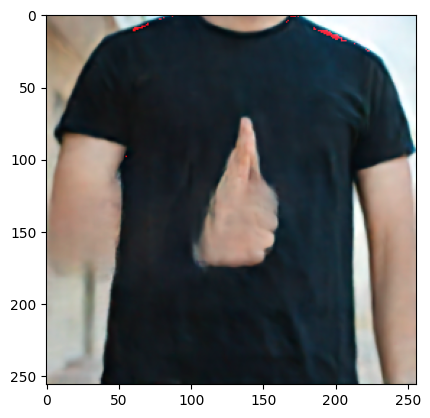

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    results[-1].clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.savefig("text_guided.png", dpi=300)
plt.show()